In [1]:
import pickle
file = open('rates.dat', 'rb') # rates that were estimated in working_file.ipynb
ar_adj = pickle.load(file)
dep_adj = pickle.load(file)
file.close()

In [9]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f2f2f2'
%matplotlib inline

In [15]:
def sim_station(arrival_rate, departure_rate, days_):
    
    '''
    simulate station occupancy: it can be modelled as a M/M/1 queue without waiting time
    or as a sum of 2 independent time-inhomogeneous Poisson processes;
    we approximate continuous intensity rate with piecewise-constant function 
    
    '''
    
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    k = 1
    inds = []
    realizations = []
    
    
    for i in range(days_):
        
        #simulate one realization of arrival process 
        rates = arrival_rate.values
        arrival_times = []
        for hour in range(len(rates)):
            n_arrivals = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates))  
            for x in range(n_arrivals):
                arrival_times = np.append(arrival_times, np.random.uniform() + hour)
        arrival_times = sorted(arrival_times)
        
        #simulate one realization of departure process 
        rates = [abs(x) for x in departure_rate.values]
        departure_times = []
        for hour in range(len(rates)):
            n_departures = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates)) 
            for x in range(n_departures):
                departure_times = np.append(departure_times, np.random.uniform() + hour)
        departure_times = sorted(departure_times)
        
        #combine them in one graph using random starting occupancy
        arr = pd.DataFrame(arrival_times)
        arr['arr'] = np.ones(len(arrival_times))
        dep = pd.DataFrame(departure_times)
        dep['arr'] = [-x for x in np.ones(len(departure_times))]
        arr = arr.append(dep).sort_values(by = 0)
        start = np.random.randint(26, 31)
        occupancy = start + np.cumsum(arr['arr'])
        arr['occupancy'] = occupancy        
        arr = arr.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')
            if '24:' in x:
                result[j] = ('23:59')

        arr.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1 = arr['occupancy'].resample('2T').mean().bfill()
        arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        ind = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1+k))
        inds.append(ind)
        k += 1
        arr1 = arr1.apply(lambda x: round(x, 0))
        ax.plot(arr1, alpha = 0.4, color = 'dodgerblue')
        realizations.append(arr1)
    return realizations, inds



In [22]:
realizations, inds = sim_station(ar_adj, dep_adj, days_ = 25)

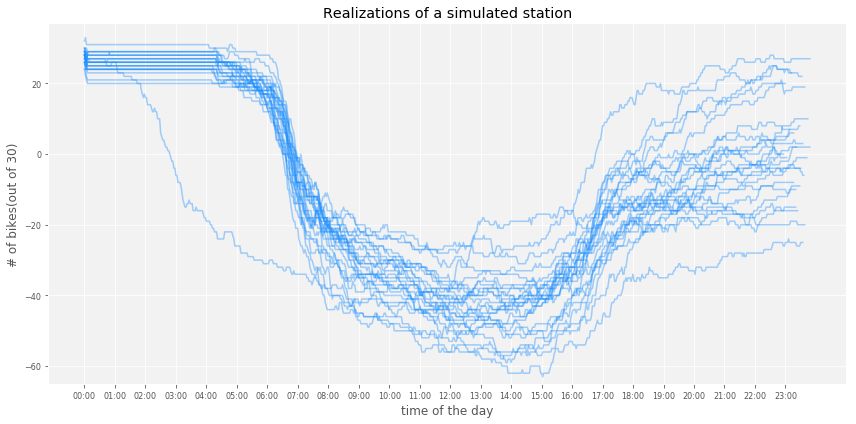

In [19]:
inds = [x for subset in inds for x in subset]
realizations = [x for subset in realizations for x in subset]
realizations = pd.Series(realizations)
realizations.index = inds

fig, ax = plt.subplots(1,1,figsize=(12,6))
days = np.unique(realizations.index.date)
for day in days:
    plt.plot(realizations[realizations.index.date == day].values, alpha = .4, color = 'dodgerblue')
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Realizations of a simulated station')
ax.set_xlabel('time of the day')
ax.set_ylabel('# of bikes(out of 30)')
ax.set_ylim(-65,37)
plt.tight_layout();

In [23]:
def sim_finite_station(arrival_rate, departure_rate, days_):
    '''
    same as the previous function but now occupancy can't get below 0 or above 30
    
    '''
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    plt.title('Realizations of a simulated finite station')
    k = 1
    inds = []
    realizations = []
    for i in range(days_):
        rates = arrival_rate.values
        arrival_times = []
        for hour in range(len(rates)):
            n_arrivals = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates))  
            for x in range(n_arrivals):
                arrival_times = np.append(arrival_times, np.random.uniform() + hour)
        arrival_times = sorted(arrival_times)

        rates = [abs(x) for x in departure_rate.values]
        departure_times = []
        for hour in range(len(rates)):
            n_departures = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates)) 
            for x in range(n_departures):
                departure_times = np.append(departure_times, np.random.uniform() + hour)
        departure_times = sorted(departure_times)

        arr = pd.DataFrame(arrival_times)
        arr['arr'] = np.ones(len(arrival_times))
        dep = pd.DataFrame(departure_times)
        dep['arr'] = [-x for x in np.ones(len(departure_times))]
        arr = arr.append(dep).sort_values(by = 0)

        start = np.random.randint(26, 31)
        occupancy = []
        prev = start
        for x in arr['arr']:
            if (prev + x >= 0) & (prev + x <= 30):
                prev = prev + x
                occupancy.append(prev)
            else:       
                occupancy.append(prev)
        #occupancy = start + np.cumsum(arr['arr'])
        arr['occupancy'] = occupancy        
        arr = arr.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')

        arr.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1 = arr['occupancy'].resample('2T').mean().bfill()
        arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        ind = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1+k))
        inds.append(ind)
        k += 1
        arr1 = arr1.apply(lambda x: round(x, 0))
        ax.plot(arr1, alpha = 0.3, color = 'dodgerblue')
        realizations.append(arr1)

    return realizations, inds

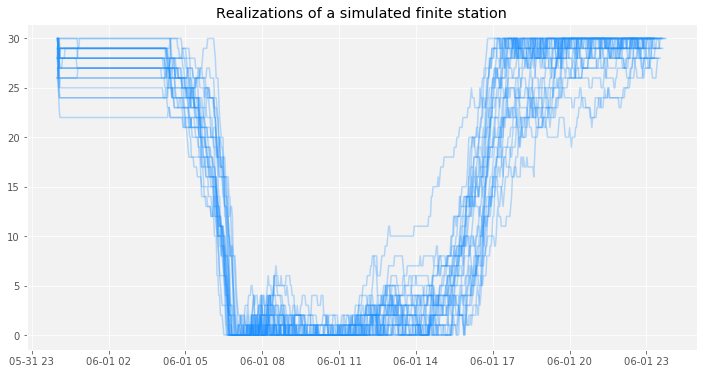

In [24]:
realizations, inds = sim_finite_station(ar_adj, dep_adj, days_ = 25)